# M-I coupling with Lompe

M-I coupling: AMPS + Hardy / EUV conductance?

In [1]:
%matplotlib inline
import lompe
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import pandas as pd
import apexpy
from scipy.interpolate import griddata
from scipy.ndimage import median_filter

Re = 6371.2e3                   # Earth's radius [m]
HI = 110e3                      # Ionospheric altitude [m]
stencil_size = 1                # size of stencil for differentiation 
time = dt.datetime(2005, 9, 10) # used for coordinate conversion, map plotting, and solar zenith angles (sza)

#### Cubed sphere grid

In [2]:
L, W, Lres, Wres = 4000e3, 4000e3, 100e3, 100e3  # m
projection = lompe.cs.CSprojection(position = (-30, 80), orientation = 0)        # east, west oriented xi-axis
grid = lompe.cs.CSgrid(projection, L, W, Lres, Wres, R = Re+HI) # set to ionospheric altitude
SKIP = 20 # how many grid points to skip when smoothing 

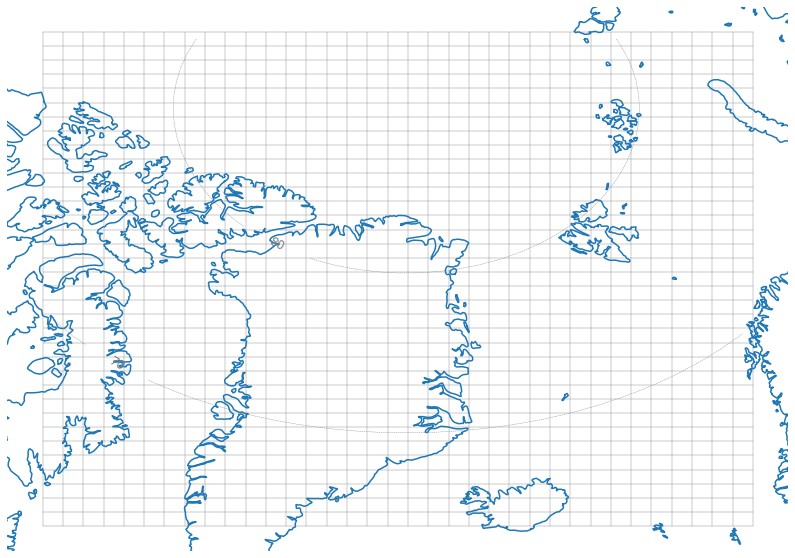

In [3]:
fig, ax = plt.subplots(figsize = (14, 10))
ax.set_axis_off()

# grid
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    ax.plot(xi, eta, color = 'grey', linewidth = .4)
xlim, ylim = ax.get_xlim(), ax.get_ylim()
# coastlines
for cl in grid.projection.get_projected_coastlines():
    ax.plot(cl[0], cl[1], color = 'C0')

# add (geographic) latitude contours
co = ax.contour(grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', linewidths = .4, levels = np.r_[-80:81:10])
ax.clabel(co, co.levels, inline = True, fontsize = 12)

ax.set_xlim(xlim)
ax.set_ylim(ylim);

##### Ionospheric conductances

In [5]:
Kp   = 4                        # for Hardy model
F107 = 100                      # sfu, for EUV conductance
refh = HI*1e-3                  # altitude for coodinate conversion [km]

# functions for conductances to be passed to the Lompe model
SH = lambda lon = grid.lon, lat = grid.lat: lompe.conductance.hardy_EUV(lon, lat, Kp, time, 'hall')
SP = lambda lon = grid.lon, lat = grid.lat: lompe.conductance.hardy_EUV(lon, lat, Kp, time, 'pedersen')

#### FACs from the AMPS model

Average Magnetic field and Polar current System [(AMPS) model](https://birkeland.uib.no/data/amps/) described in [Laundal et al. (2018)](https://doi.org/10.1029/2018JA025387).

In [6]:
# AMPS FACs
from pyamps import AMPS
# get AMPS model
m = AMPS(350, # Solar wind velocity in km/s
           0, # IMF By (GSM) in nT
          -4, # IMF Bz (GSM) in nT,
         -10, # dipole tilt angle in degrees
         100) # F107_index

# get FAC from AMPS model
a=apexpy.Apex(2015.,110)
mlat, mlon = a.geo2apex(grid.lat, grid.lon,110)
mlt=a.mlon2mlt(mlon,time)
AMPSfac = m.get_upward_current(mlat, mlt)

NB: Input data for Lompe of the `fac` datatype need to be defined on the entire grid. This is done here, as the FACs are defined in the whole region, and we have interpolated the data to the grid.

In [7]:
# field-aligned current
FACdata = lompe.Data(AMPSfac.flatten(), np.vstack((grid.lon.flatten(), grid.lat.flatten())), datatype='fac')

##### Construct the Lompe model
Now, we can initialize a Lompe model object, add the input data, and run the inversion to get the model vector, $\mathbf{m}$, that can be used to obtain other ionospheric parameters in the region. An explanation of the inversion technique and regularization parameters can be found in Section 3.3 of [Laundal et al. (2022)](https://doi.org/10.1029/2022JA030356).

In [8]:
# initialize model
model = lompe.Emodel(grid, Hall_Pedersen_conductance = (SH, SP))

# add input data
model.add_data(FACdata)

# Run inversion. l1 and l2 are regularization parameters that control the damping of 
# 1) model norm, and 2) gradient of SECS amplitudes (charges) in magnetic eastward direction
model.run_inversion(l1 = 0.01, l2 = 0.2);

#### Plot and save

KeyboardInterrupt: 

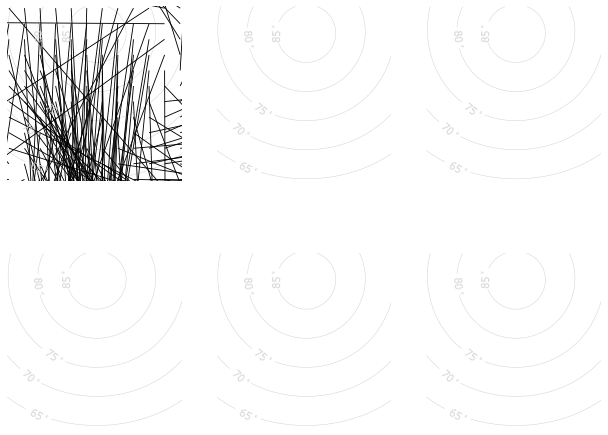

In [12]:
fig = lompe.lompeplot(model, include_data=False, savekw = {'fname':'./output_figures/LompeforMIcoupling.pdf'})
# also save png
fig.savefig('./output_figures/LompeforMIcoupling.png')

The top row shows, from left to right: 
- Convection flow field and electric potential contours
- horizontal magnetic field disturbances 110 km above the ionosphere (grid altitude) as black arrows and radial current density as color contours
- horizontal ground magnetic field perturbations as black arrows and radial magnetic field perturbations as color contours
- a map that shows the grid’s position and orientation with respect to apex magnetic latitude and local time.

The bottom row shows, from left to right: 
- Pedersen conductance
- Hall conductance
- horizontal height-integrated ionospheric currents based on Lompe output
- color scale / vector scales